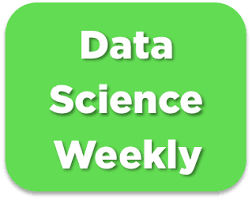

# Challenge : predict conversions 🏆🏆

### /!\ I used a template made by Jedha to achieve this project

# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns 

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"
from IPython.display import display

from dython.nominal import associations

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# Explore dataset

In [4]:
display(data.describe(include='all'))
print()
print("Percentage of missing values")
display(100*data.isna().sum()/data.shape[0])
print()
display(data.converted.value_counts())
print()
display(data.country.value_counts())
print()
display(data.new_user.value_counts())
print()
display(data.source.value_counts())

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

0    275400
1      9180
Name: converted, dtype: int64

US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64

1    195066
0     89514
Name: new_user, dtype: int64

Seo       139477
Ads        80027
Direct     65076
Name: source, dtype: int64

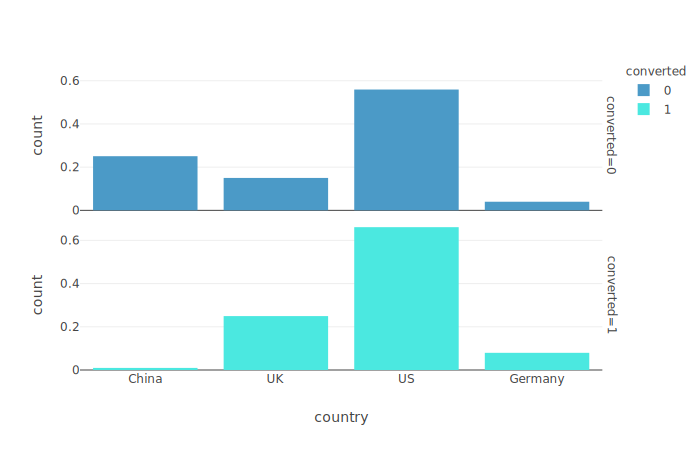

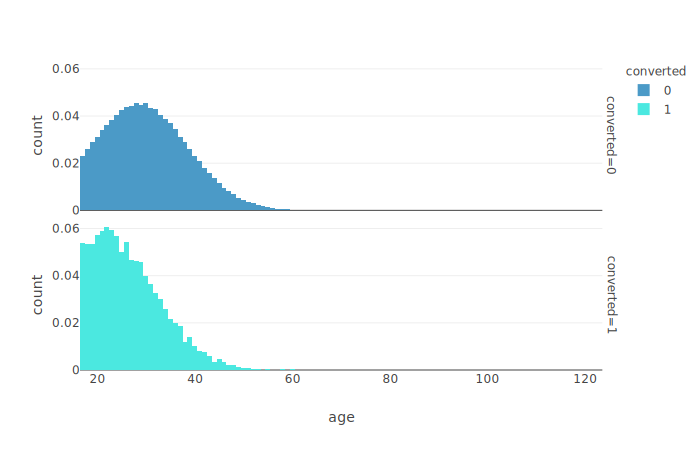

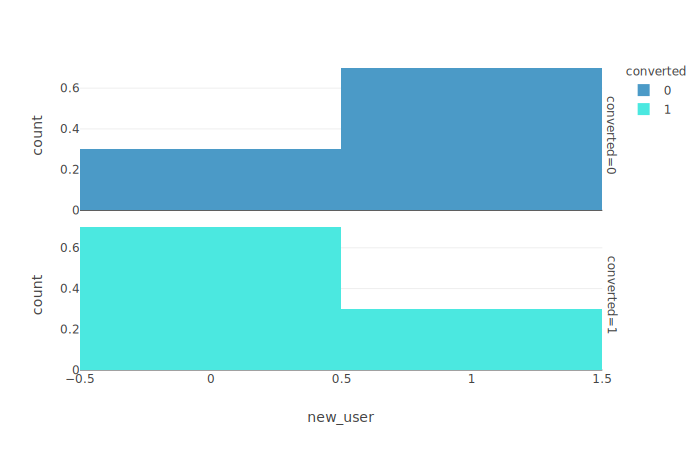

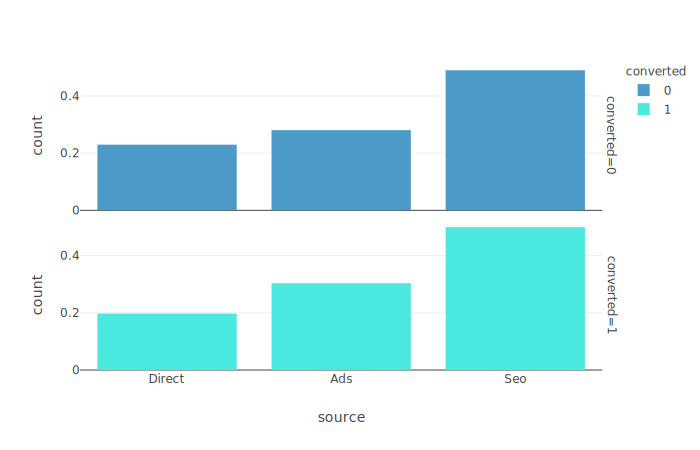

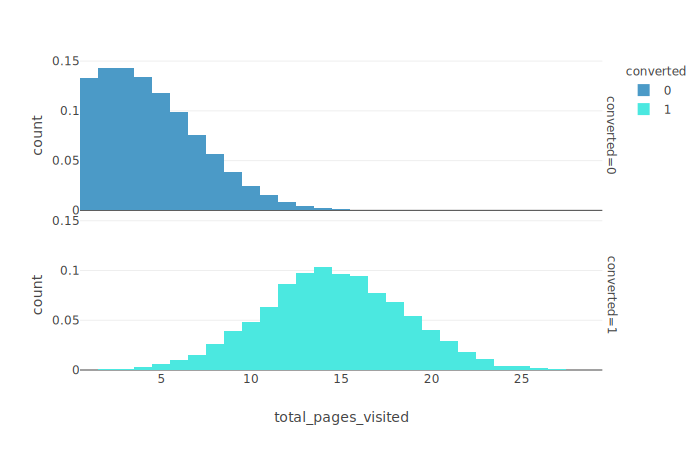

In [5]:
features = data.drop('converted', axis=1).columns
for f in features:
    fig = px.histogram(data, f, color = 'converted', facet_row = 'converted', histnorm = 'probability')
    fig.show()

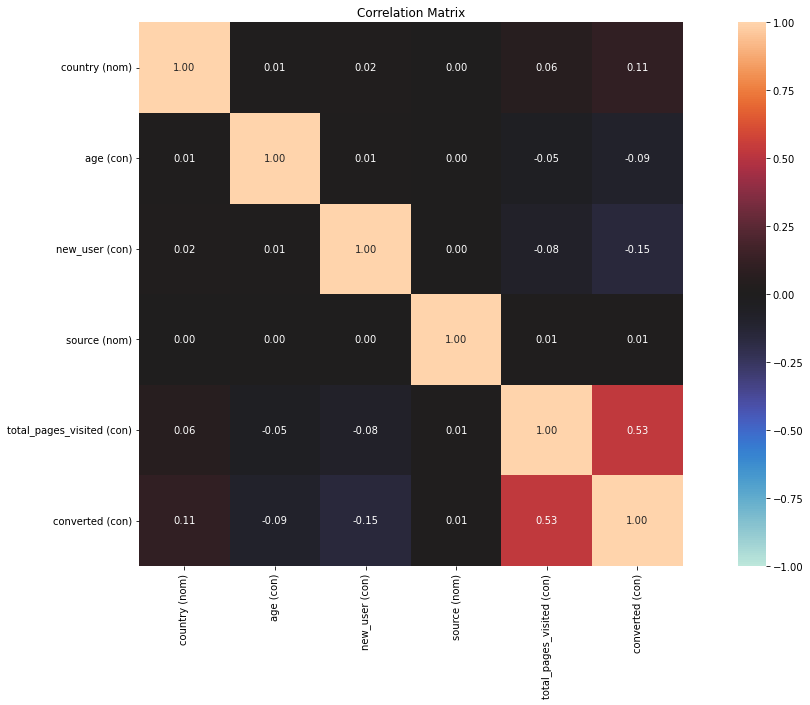

In [6]:
# Correlation matrix between all our variables
    ### Pearson's R for continuous-continuous cases
    ### Correlation Ratio for categorical-continuous cases
    ### Cramer's V or Theil's U for categorical-categorical cases
associations(data,figsize=(20,10), title='Correlation Matrix', mark_columns=True);

We will keep ages in : $[mean - 3std, mean + 3std]$ 

In [7]:
# Drop outliers 
data = data.loc[(data["age"].between(data["age"].mean() - 3*data["age"].std(), data["age"].mean() + 3*data["age"].std())) | (data["age"].isna()),:]
data.shape

(283563, 6)

In [8]:
features_list = ['total_pages_visited']
numeric_indices = [0]
categorical_indices = []
target_variable = 'converted'

Train and test sets with only total_pages_visited

In [9]:
X_univar = data.loc[:, features_list]
Y_univar = data.loc[:, target_variable]

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_univar_train, X_univar_test, Y_univar_train, Y_univar_test = train_test_split(X_univar, Y_univar, test_size=0.2, stratify=Y_univar, random_state=0)
print("...Done.")
print()

print('Explanatory variables : ', X_univar.columns)
print()

Dividing into train and test sets...
...Done.

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



Train and test set with all the features

In [10]:
# Splitting the target from the features
X = data.drop(target_variable, axis=1)
Y = data.loc[:, target_variable]

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)
print("...Done.")
print()

print('Explanatory variables : ', X_univar.columns)
print()

Dividing into train and test sets...
...Done.

Explanatory variables :  Index(['total_pages_visited'], dtype='object')



## Preprocessing pipelines

### Preprocessing for the univariate model

In [11]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

featureencoder = StandardScaler()
X_univar_train = featureencoder.fit_transform(X_univar_train)
print("...Done")
print(X_univar_train[0:5,:])

print("Encoding categorical features and standardizing numerical features...")

X_univar_test = featureencoder.transform(X_univar_test)
print("...Done")
print(X_univar_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 1.2320414 ]
 [-0.86035747]
 [ 0.03638491]
 [-0.86035747]
 [-0.56144334]]
Encoding categorical features and standardizing numerical features...
...Done
[[ 0.63421315]
 [-0.26252922]
 [-1.15927159]
 [-0.56144334]
 [-0.56144334]]


### Preprocessing for multivariate models

In [12]:
# Detect automatically numeric and categorical features
features = np.delete(data.columns, 5)
numeric_features = []
categorical_features = []


for col in features:
    if ('float' in str(data[col].dtype).lower()) or ('int' in str(data[col].dtype).lower()):
        numeric_features.append(col)
    else:
        categorical_features.append(col)
print('Numeric features : ', numeric_features)
print('Categorical features : ', categorical_features)

Numeric features :  ['age', 'new_user', 'total_pages_visited']
Categorical features :  ['country', 'source']


In [13]:
# Preprocessor instanciation
numeric_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('std', StandardScaler())

])

categorical_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(drop='first', handle_unknown='ignore'))

])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [14]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(X_train[0:2,:])

[[-1.53585634  0.67766304  1.2320414   0.          0.          1.
   0.          0.        ]
 [-0.30274697  0.67766304 -0.86035747  0.          0.          1.
   0.          0.        ]]


## Trainings

### Univariate logistic regression

In [15]:
# Train model
print("Train model...")
classifier = LogisticRegression() 
classifier.fit(X_univar_train, Y_univar_train)
print("...Done.")

Train model...
...Done.


In [16]:
# Predictions on training set
print("Predictions on training set...")
Y_univar_train_pred = classifier.predict(X_univar_train)
print("...Done.")
print(Y_univar_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_univar_test_pred = classifier.predict(X_univar_test)
print("...Done.")
print(Y_univar_test_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 1 0 0]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



Confusion matrix on train set : 
[[218553    959]
 [  2894   4444]]

Confusion matrix on test set : 
[[54642   236]
 [  753  1082]]



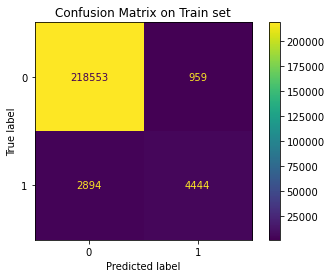

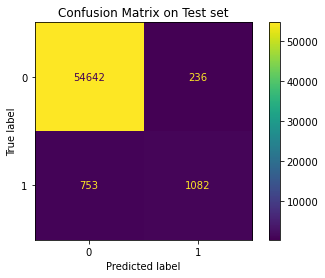

In [17]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_univar_train, Y_univar_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_univar_test, Y_univar_test_pred))
print()

# Visualize confusion matrices
_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Train set") 
ConfusionMatrixDisplay.from_estimator(classifier, X_univar_train, Y_univar_train, ax=ax)
plt.show()

_ , ax = plt.subplots() 
ax.set(title="Confusion Matrix on Test set")
ConfusionMatrixDisplay.from_estimator(classifier, X_univar_test, Y_univar_test, ax=ax)
plt.show()

In [18]:
print("recall on training set : ", recall_score(Y_train, Y_univar_train_pred))
print("recall on test set : ", recall_score(Y_test, Y_univar_test_pred))

recall on training set :  0.6056146088852549
recall on test set :  0.5896457765667575


### Multivariate logistic regression

In [19]:
# Train model
print("Train model...")
classifier_mv = LogisticRegression() 
classifier_mv.fit(X_train, Y_train)
print("...Done.")


Train model...
...Done.


### Random forest

In [20]:
# Perform grid search
print("Grid search...")
classifier_rf = RandomForestClassifier()

# Params to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 40, 60, 100]
}
gridsearch_rf = GridSearchCV(classifier_rf, param_grid = params, cv = 3) 
gridsearch_rf.fit(X_train, Y_train)


Grid search...


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 40, 60, 100]})

### Adaboost with decision trees

In [21]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
adaboost_dt = AdaBoostClassifier(decision_tree)

# Params to be tested
params = {
    'base_estimator__max_depth': [8, 10, 12],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gridsearch_adb_dt = GridSearchCV(adaboost_dt, param_grid = params, cv = 3) 
gridsearch_adb_dt.fit(X_train, Y_train)


Grid search...
{'base_estimator__max_depth': [8, 10, 12], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}


GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [8, 10, 12],
                         'base_estimator__min_samples_leaf': [1, 2, 3],
                         'base_estimator__min_samples_split': [6, 8, 10],
                         'n_estimators': [2, 4, 6, 8, 10, 12]})

### Gradient boost

In [22]:
# Perform grid search
print("Grid search...")
gradientboost = GradientBoostingClassifier()

# Params to be tested
params = {
    'max_depth': [8, 10, 12],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gridsearch_gb = GridSearchCV(gradientboost, param_grid = params, cv = 3)
gridsearch_gb.fit(X_train, Y_train)

Grid search...
{'max_depth': [8, 10, 12], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [6, 8, 10], 'n_estimators': [2, 4, 6, 8, 10, 12]}


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [2, 4, 6, 8, 10, 12]})

### XGBoost

In [23]:
# Perform grid search
xgboost = XGBClassifier()

# Params to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_child_weight': [1, 2, 4, 6, 8],
    'n_estimators': [2, 4, 6, 8, 10, 12]
}
print(params)
gridsearch_xgb = GridSearchCV(xgboost, param_grid = params, cv = 3)
gridsearch_xgb.fit(X_train, Y_train)

{'max_depth': [4, 6, 8, 10], 'min_child_weight': [1, 2, 4, 6, 8], 'n_estimators': [2, 4, 6, 8, 10, 12]}


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_child_weight': [1, 2, 4, 6, 8],
                         'n_estimators': [2, 4, 6, 8, 10, 12]})

### Voting

In [24]:
voting = VotingClassifier(estimators=[
                                    ("logistic", classifier_mv),
                                    ("random_f", gridsearch_rf),
                                    ("adaboost", gridsearch_adb_dt),
                                    ("gradientboost", gridsearch_gb),
                                    ("xgboost", gridsearch_xgb)
                                    ],
                         voting="hard")
voting.fit(X_train, Y_train)

VotingClassifier(estimators=[('logistic', LogisticRegression()),
                             ('random_f',
                              GridSearchCV(cv=3,
                                           estimator=RandomForestClassifier(),
                                           param_grid={'max_depth': [2, 4, 6, 8,
                                                                     10],
                                                       'min_samples_leaf': [1,
                                                                            2,
                                                                            5],
                                                       'min_samples_split': [2,
                                                                             4,
                                                                             8],
                                                       'n_estimators': [10, 40,
                                                                        60,
                                                                        100]})),
                             ('adaboost',
                              GridSearchCV(cv=3,
                                           estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier()),
                                           pa...
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None, ...),
                                           param_grid={'max_depth': [4, 6, 8,
                                                                     10],
                                                       'min_child_weight': [1,
                                                                            2,
                                                                            4,
                                                                            6,
                                                                            8],
                                                       'n_estimators': [2, 4, 6,
                                                                        8, 10,
                                                                        12]}))])

## Performance assessment

In [25]:
scores_df = pd.DataFrame(columns = ['model', 'accuracy', 'set'])

print("Multivariate logistic regression performances :")
print("f1-score on train set : ", f1_score(Y_train, classifier_mv.predict(X_train)))
print("f1-score on test set : ", f1_score(Y_test, classifier_mv.predict(X_test)))
print()

print("Random forest performances : ")
print("f1-score on training set : ", f1_score(Y_train, gridsearch_rf.predict(X_train)))
print("f1-score on test set : ", f1_score(Y_test, gridsearch_rf.predict(X_test)))
print()

print("AdaBoost performances : ")
print("f1-score on training set : ", f1_score(Y_train, gridsearch_adb_dt.predict(X_train)))
print("f1-score on test set : ", f1_score(Y_test, gridsearch_adb_dt.predict(X_test)))
print()

print("Gradient Boost performances : ")
print("f1-score on training set : ", f1_score(Y_train, gridsearch_gb.predict(X_train)))
print("f1-score on test set : ", f1_score(Y_test, gridsearch_gb.predict(X_test)))
print()

print("XGBoost performances : ")
print("f1-score on training set : ", f1_score(Y_train, gridsearch_xgb.predict(X_train)))
print("f1-score on test set : ", f1_score(Y_test, gridsearch_xgb.predict(X_test)))
print()

print("Voting performances : ")
print("f1-score on training set : ", f1_score(Y_train, voting.predict(X_train)))
print("f1-score on test set : ", f1_score(Y_test, voting.predict(X_test)))
print()

scores_df = scores_df.append({'model': 'univar_logistic_regression', 'accuracy': f1_score(Y_univar_train, Y_univar_train_pred), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'univar_logistic_regression', 'accuracy': f1_score(Y_univar_test, Y_univar_test_pred), 'set': 'test'}, ignore_index = True)

scores_df = scores_df.append({'model': 'multivar_logistic_regression', 'accuracy': f1_score(Y_train, classifier_mv.predict(X_train)), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'multivar_logistic_regression', 'accuracy': f1_score(Y_test, classifier_mv.predict(X_test)), 'set': 'test'}, ignore_index = True)


scores_df = scores_df.append({'model': 'random_forest', 'accuracy': f1_score(Y_train, gridsearch_rf.predict(X_train)), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'random_forest', 'accuracy': f1_score(Y_test, gridsearch_rf.predict(X_test)), 'set': 'test'}, ignore_index = True)

scores_df = scores_df.append({'model': 'adaboost', 'accuracy': f1_score(Y_train, gridsearch_adb_dt.predict(X_train)), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'adaboost', 'accuracy': f1_score(Y_test, gridsearch_adb_dt.predict(X_test)), 'set': 'test'}, ignore_index = True)

scores_df = scores_df.append({'model': 'gradient_boost', 'accuracy': f1_score(Y_train, gridsearch_gb.predict(X_train)), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'gradient_boost', 'accuracy': f1_score(Y_test, gridsearch_gb.predict(X_test)), 'set': 'test'}, ignore_index = True)

scores_df = scores_df.append({'model': 'xg_boost', 'accuracy': f1_score(Y_train, gridsearch_xgb.predict(X_train)), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'xg_boost', 'accuracy': f1_score(Y_test, gridsearch_xgb.predict(X_test)), 'set': 'test'}, ignore_index = True)

scores_df = scores_df.append({'model': 'voting', 'accuracy': f1_score(Y_train, voting.predict(X_train)), 'set': 'train'}, ignore_index = True)
scores_df = scores_df.append({'model': 'voting', 'accuracy': f1_score(Y_test, voting.predict(X_test)), 'set': 'test'}, ignore_index = True)

scores_df.sort_values(by = [ 'set', 'accuracy'], ascending = False)

Multivariate logistic regression performances :
f1-score on train set :  0.7649186256781194
f1-score on test set :  0.7568723274282224

Random forest performances : 
f1-score on training set :  0.7632872503840246
f1-score on test set :  0.7460267996260518

AdaBoost performances : 
f1-score on training set :  0.7666465802952698
f1-score on test set :  0.7454934311029637

Gradient Boost performances : 
f1-score on training set :  0.7519206145966709
f1-score on test set :  0.7219701879455604

XGBoost performances : 
f1-score on training set :  0.7674401253450721
f1-score on test set :  0.7557856272838002

Voting performances : 
f1-score on training set :  0.7669001218026796
f1-score on test set :  0.7491493968450357



,model,accuracy,set
10,xg_boost,0.767440,train
12,voting,0.766900,train
6,adaboost,0.766647,train
2,multivar_logistic_regression,0.764919,train
4,random_forest,0.763287,train
8,gradient_boost,0.751921,train
0,univar_logistic_regression,0.697590,train
3,multivar_logistic_regression,0.756872,test
11,xg_boost,0.755786,test
13,voting,0.749149,test


# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [26]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier_mv.fit(X,Y)

LogisticRegression()

In [27]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)
print(data_without_labels.shape)

X_without_labels = preprocessor.transform(data_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
(31620, 5)
...Done
[[-0.30274697 -1.47565965  3.32444027  0.          1.          0.
   0.          1.        ]
 [-1.04261259  0.67766304  0.03638491  0.          1.          0.
   1.          0.        ]
 [ 0.19049678  0.67766304 -1.15927159  0.          0.          0.
   0.          1.        ]
 [ 0.19049678  0.67766304  0.33529903  0.          0.          1.
   0.          0.        ]
 [-0.67267978 -1.47565965 -0.56144334  0.          0.          0.
   0.          1.        ]]


In [28]:
# Make predictions wit the voting classifier model
data_without_labels["converted"] = classifier_mv.predict(X_without_labels)

# Create a .csv file
data_without_labels.to_csv('conversion_data_test_predictions_rachidatou_votingclassifier.csv', index=False)

## Feature importance

In [29]:
# Get feature names from preprocessing pipeline
num_names = preprocessor.transformers_[0][1][1].get_feature_names_out(numeric_features)
cat_names = preprocessor.transformers_[1][1][1].get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_names, cat_names], axis=0)

# Create a Dataframe with features and the coefficients associated
coef_mv_logreg = pd.DataFrame(index = feature_names.T, data = classifier_mv.coef_.T, columns=["coefficients"])
coef_mv_logreg['abs_coefficients'] = abs(coef_mv_logreg.coefficients)

print(coef_mv_logreg[coef_mv_logreg.abs_coefficients>0].shape)
print("Logistic regression Coefficients'")

coef_mv_logreg.loc[coef_mv_logreg.abs_coefficients>0, :].sort_values(by='abs_coefficients', ascending=False)

(8, 2)
Linear regression Coefficients'


,coefficients,abs_coefficients
country_Germany,3.641809,3.641809
country_UK,3.481351,3.481351
country_US,3.132037,3.132037
total_pages_visited,2.537865,2.537865
new_user,-0.802468,0.802468
age,-0.606177,0.606177
source_Direct,-0.213657,0.213657
source_Seo,-0.028744,0.028744


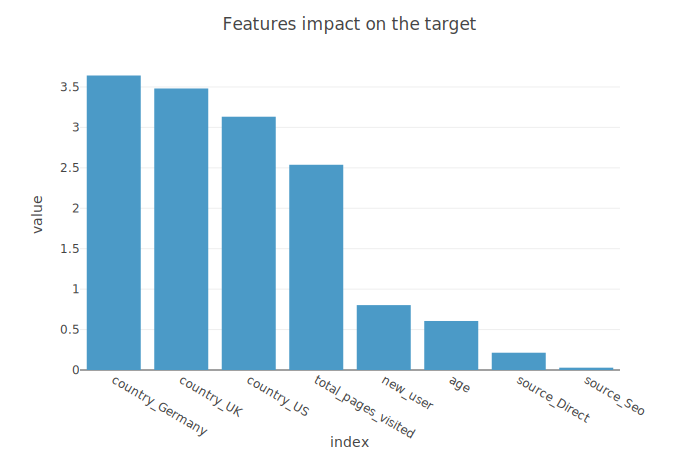

In [30]:
# Plot coefficients
feature_importance = abs(coef_mv_logreg.coefficients).sort_values(ascending=False).loc[abs(coef_mv_logreg.coefficients)>0,]
fig = px.bar(feature_importance)
fig.update_layout(showlegend = False, 
                  title = 'Features impact on the target')
fig.show()

## Conclusion

The XGBoost classifier gives the *best* performances. Logistic regression alseo gives good performances and is easier and faster to train.